# Solar Power Generation Prediction & Fault Analysis

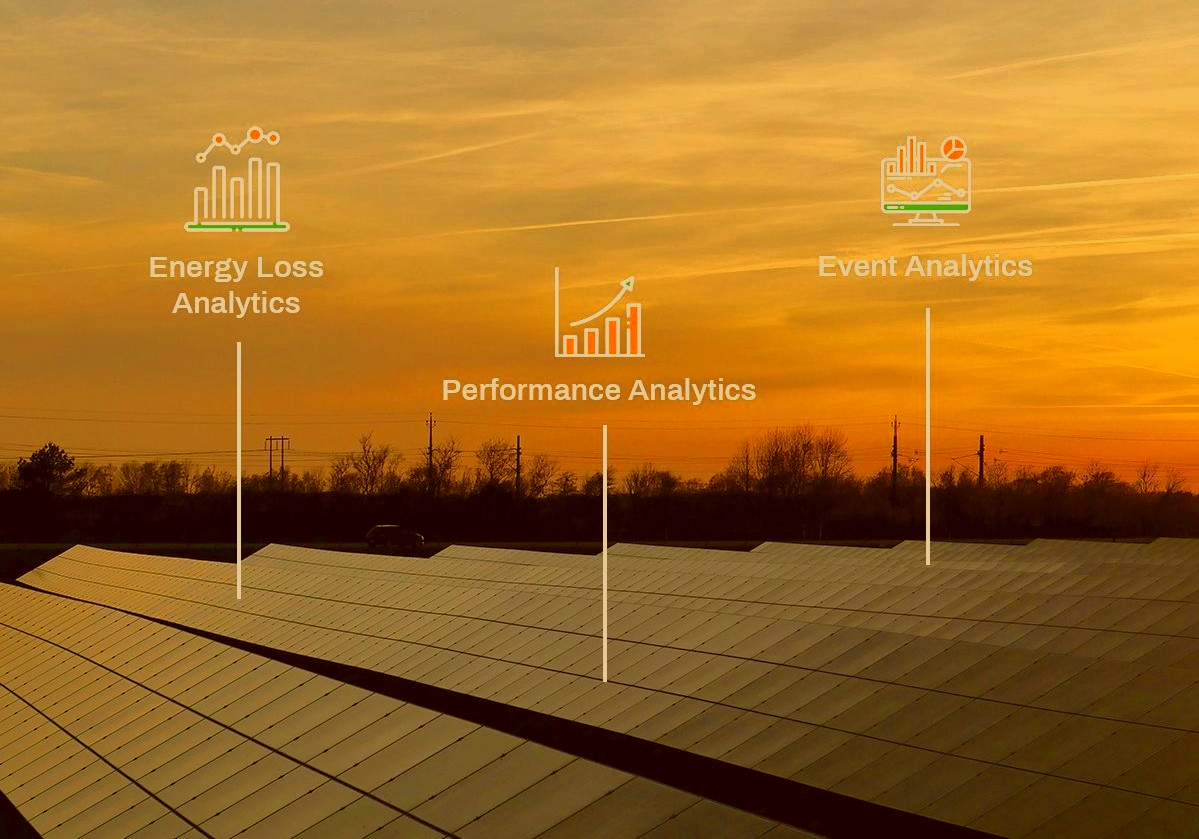

#### Prepared By - Akash Kokne

#### Dataset

Given dataset, We try to meet solar analysis challenges and predict/forecast the plant output to the extent possible which can be used for a better Grid Management/Stability.
1. Plant Generation Data
2. Plant Weather Sensor Data

##### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

##### Importing Power Generation & Weather Sensor Data

In [2]:
generation_data = pd.read_csv('Plant_Generation_Data.csv')
generation_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [3]:
weather_data = pd.read_csv('Plant_Weather_Sensor_Data.csv')
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


## Exploratory Data Analysis
##### Adjust datetime

In [4]:
generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'],format = '%Y-%m-%d %H:%M')
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')

##### Merging generation data and weather sensor data  

In [5]:
df_solar = pd.merge(generation_data.drop(columns = ['PLANT_ID']), 
                    weather_data.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df_solar.sample(5)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
37088,2020-06-03 11:45:00,mqwcsP2rE7J0TFp,850.586667,831.866667,2381.200000,5.937264e+08,29.695797,42.215615,0.600780
52859,2020-06-10 23:15:00,Quc1TzYxW2pYoWX,0.000000,0.000000,2508.000000,3.296210e+08,24.765796,23.433154,0.000000
52522,2020-06-10 19:30:00,IQ2d7wF4YD8zU1Q,0.000000,0.000000,5627.000000,2.014958e+07,25.342977,23.659354,0.000000
57776,2020-06-13 07:15:00,4UPUqMRk7TRMgml,187.466667,183.640000,60.000000,2.632921e+06,23.963179,26.806507,0.130006
43772,2020-06-06 16:00:00,Qf4GUc1pJu5T6c6,694.586667,680.033333,7400.066667,8.385896e+08,33.603462,43.504007,0.461000


##### Adding separate time and date columns

In [6]:
# adding separate time and date columns
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.week


# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.head(5)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15


In [7]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67698 entries, 0 to 67697
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            67698 non-null  datetime64[ns]
 1   SOURCE_KEY           67698 non-null  object        
 2   DC_POWER             67698 non-null  float64       
 3   AC_POWER             67698 non-null  float64       
 4   DAILY_YIELD          67698 non-null  float64       
 5   TOTAL_YIELD          67698 non-null  float64       
 6   AMBIENT_TEMPERATURE  67698 non-null  float64       
 7   MODULE_TEMPERATURE   67698 non-null  float64       
 8   IRRADIATION          67698 non-null  float64       
 9   DATE                 67698 non-null  object        
 10  TIME                 67698 non-null  object        
 11  DAY                  67698 non-null  int64         
 12  MONTH                67698 non-null  int64         
 13  WEEK                 67698 non-

In [8]:
df_solar.isnull().sum()

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DATE                   0
TIME                   0
DAY                    0
MONTH                  0
WEEK                   0
HOURS                  0
MINUTES                0
TOTAL MINUTES PASS     0
DATE_STRING            0
dtype: int64

There is no Missing Values in the dataset

In [9]:
df_solar.describe()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,MINUTES,TOTAL MINUTES PASS
count,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.000000,67698.000000,67698.000000,67698.000000,67698.000000,67698.000000,67698.000000,67698.000000
mean,246.701961,241.277825,3294.890295,6.589448e+08,27.986756,32.607233,0.229204,15.530680,5.529705,22.563296,22.517061,714.329522
std,370.569597,362.112118,2919.448386,7.296678e+08,4.021294,11.226446,0.309365,8.527546,0.499120,1.474730,16.764084,415.672274
min,0.000000,0.000000,0.000000,0.000000e+00,20.942385,20.265123,0.000000,1.000000,5.000000,20.000000,0.000000,0.000000
25%,0.000000,0.000000,272.750000,1.996494e+07,24.570349,23.685627,0.000000,9.000000,5.000000,21.000000,15.000000,360.000000
50%,0.000000,0.000000,2911.000000,2.826276e+08,26.910352,27.433723,0.018554,16.000000,6.000000,23.000000,30.000000,720.000000
75%,446.591667,438.215000,5534.000000,1.348495e+09,30.912601,40.019036,0.431027,22.000000,6.000000,24.000000,45.000000,1080.000000
max,1420.933333,1385.420000,9873.000000,2.247916e+09,39.181638,66.635953,1.098766,31.000000,6.000000,25.000000,45.000000,1425.000000


## Data Pre-Processing
##### Converting 'SOURCE_KEY' from categorical form to numerical form

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_solar['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_solar['SOURCE_KEY'])
df_solar.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING,SOURCE_KEY_NUMBER
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,0
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,1
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,2
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,3
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,4


## Data Visualization

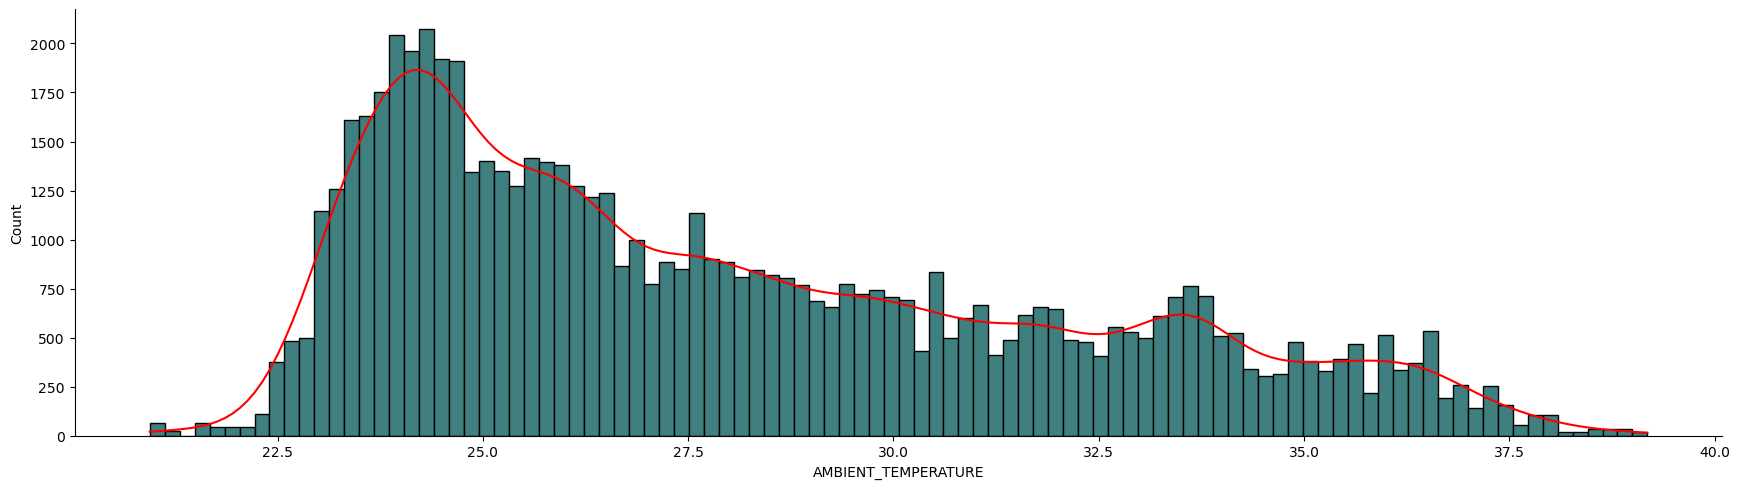

In [11]:
sns.displot(data=df_solar, x="AMBIENT_TEMPERATURE", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5)

In [12]:
df_solar['DATE'].nunique()

34

The data of solar power generation is of 34 days

## Ideal Graph of Solar Power Generation

<img src="https://www.solarmarket.com.au/wp-content/uploads/2021/04/solar-output-graph.png" alt="Solar Panel" width="50%">
</center>

## Faults & Abnormalities detection in solar power plant generation

### Plot of DC_POWER generation on per day basis.

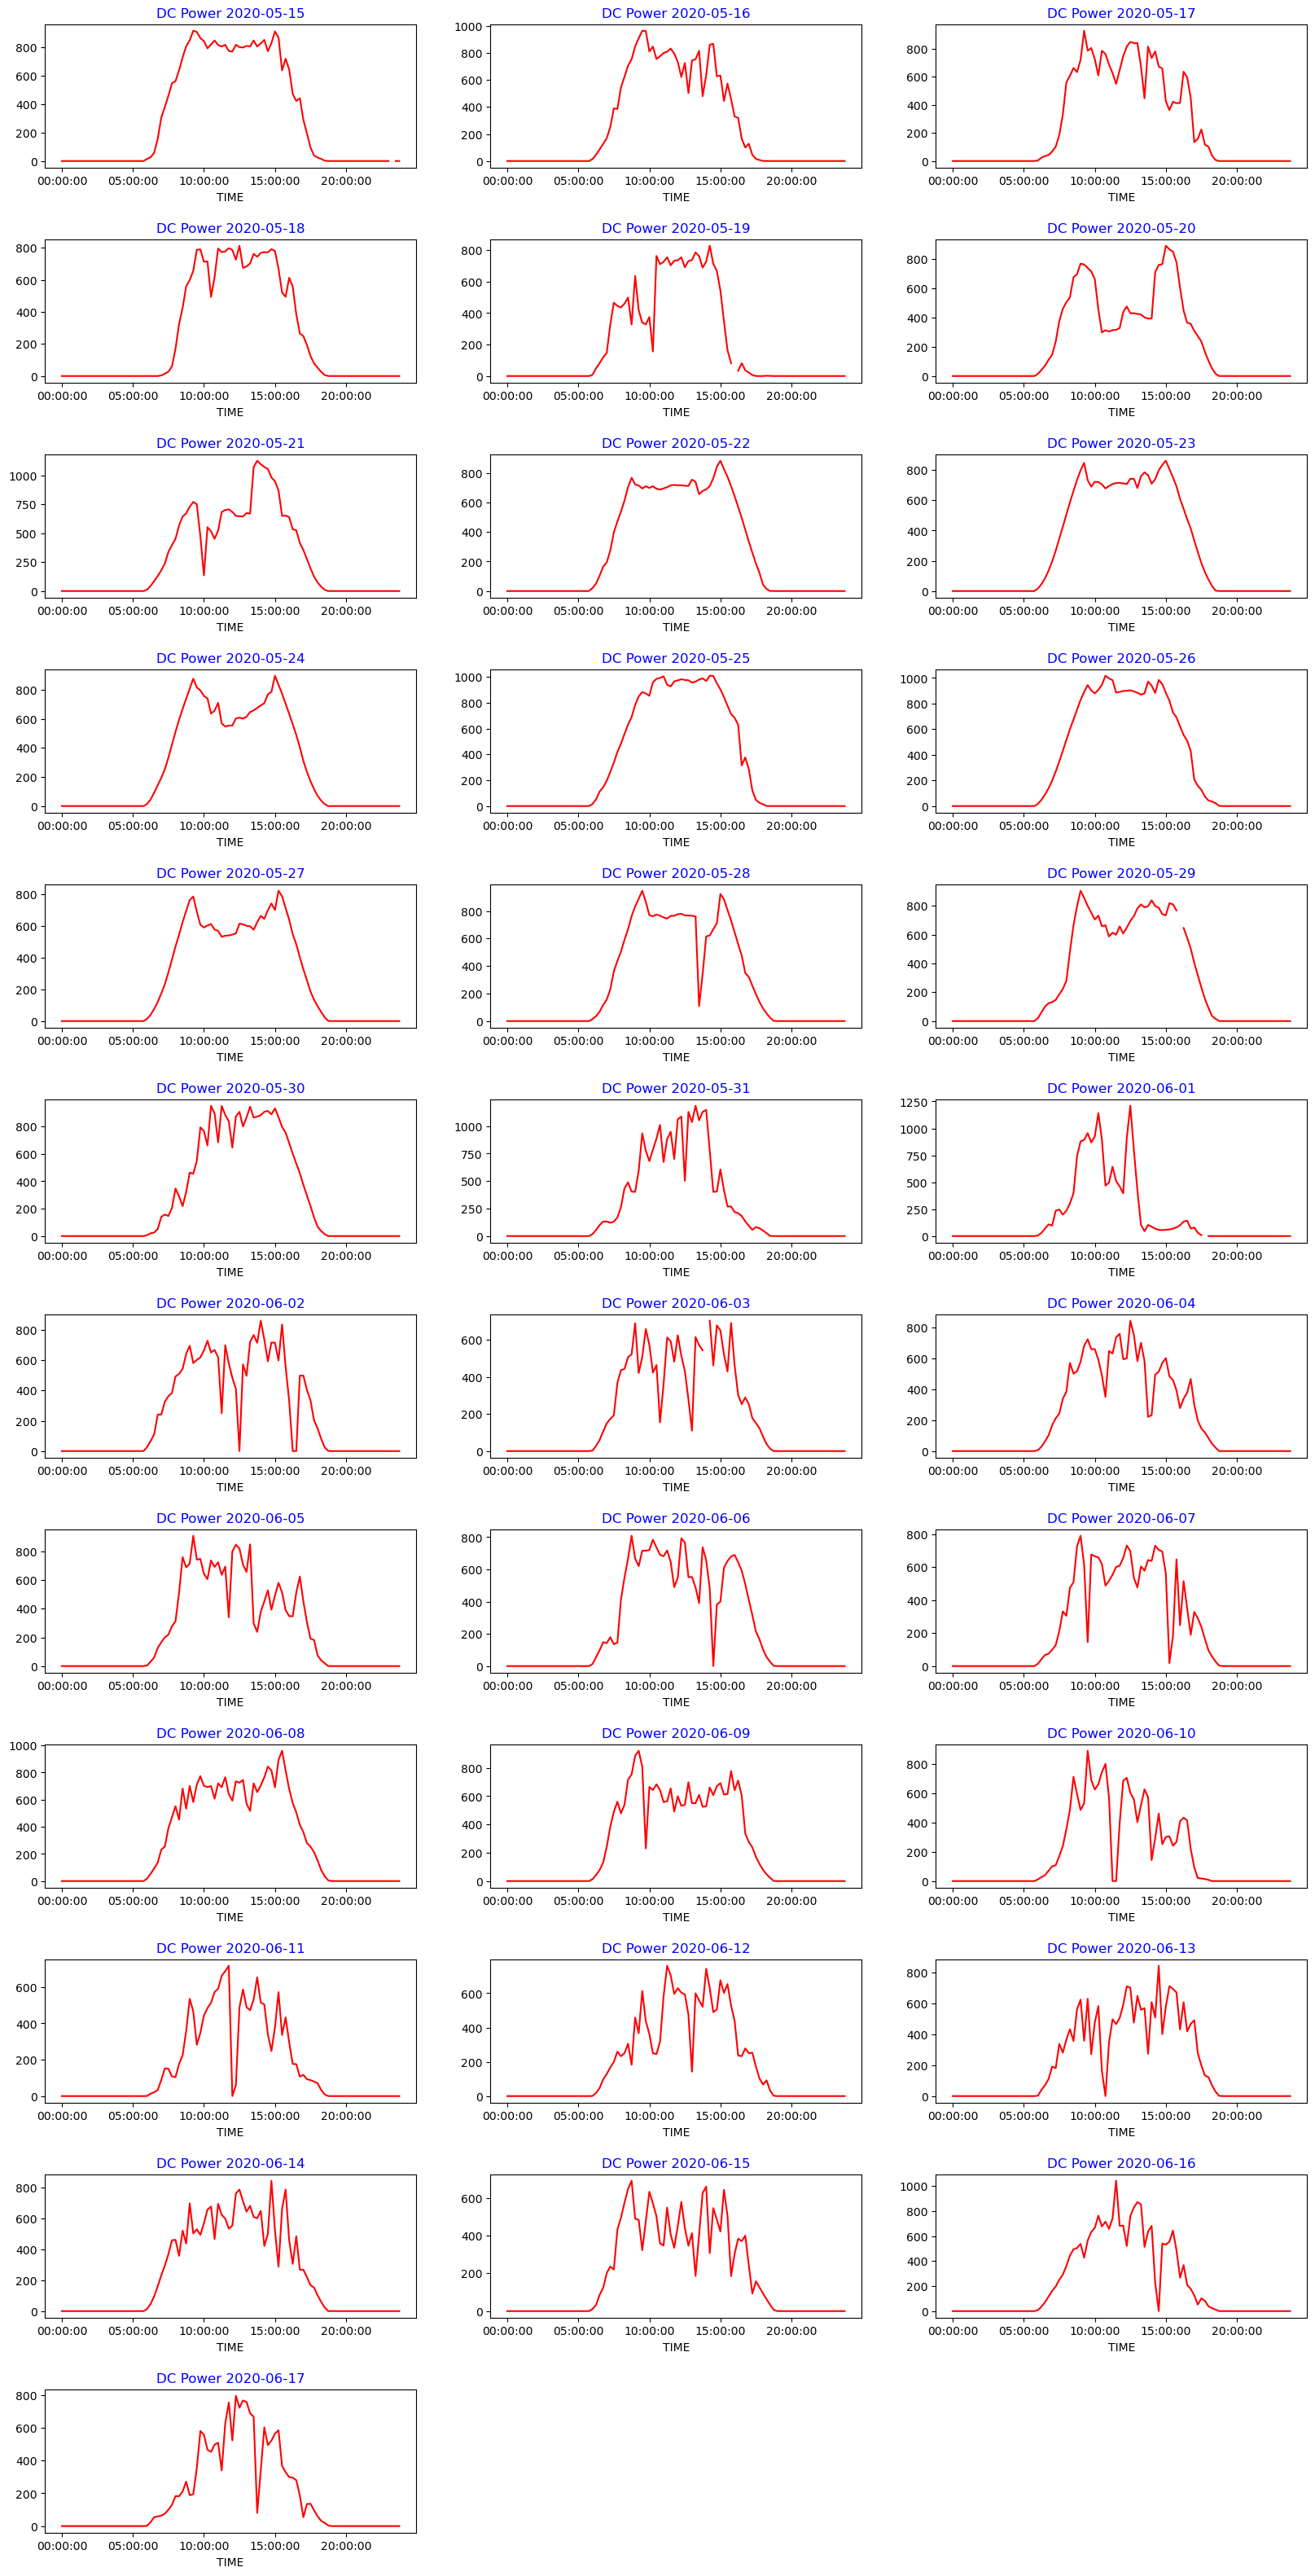

In [13]:
solar_dc = df_solar.pivot_table(values='DC_POWER', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='DC Power'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_dc, row=12, col=3)

From the per day DC_POWER generation graph we can find that, most of the days there is a some fluctuation in the power generation.

#### Abnormalities in DC_POWER Generation

Less Fluctuation in DC_POWER generation is observed in these days.

1. 2020-05-15
2. 2020-05-22
3. 2020-05-23
4. 2020-05-25
5. 2020-05-26

High Fluctuation in DC_POWER generation is observed in these days.

1. 2020-05-17
2. 2020-05-19
3. 2020-05-30
4. 2020-06-02
5. 2020-06-03
6. 2020-06-04
7. 2020-06-12
8. 2020-06-14
9. 2020-06-15
10. 2020-06-17

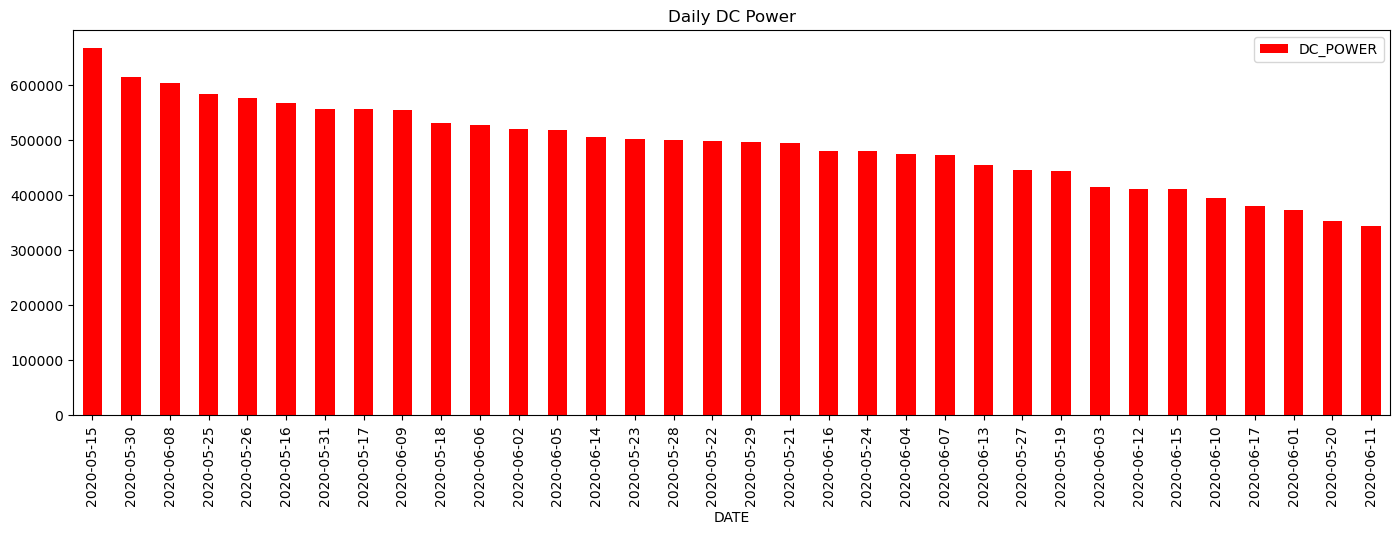

In [14]:
daily_dc = df_solar.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily DC Power')
plt.show()

Form the per day DC_POWER generation graph we can find the average power generation per day.

Highest average DC_POWER Generation is on: 2020-05-15

Lowest average DC_POWER Generation is on : 2020-06-11

This Large variation in the DC_POWER generation is due to the fault in the system or due to weather change, which needs to study further. But from this bar plot we find the day on which there is highest DC_POWER is generated and the day with the lowest DC_POWER generated.

## Plot of IRRADIATION generation on per day basis

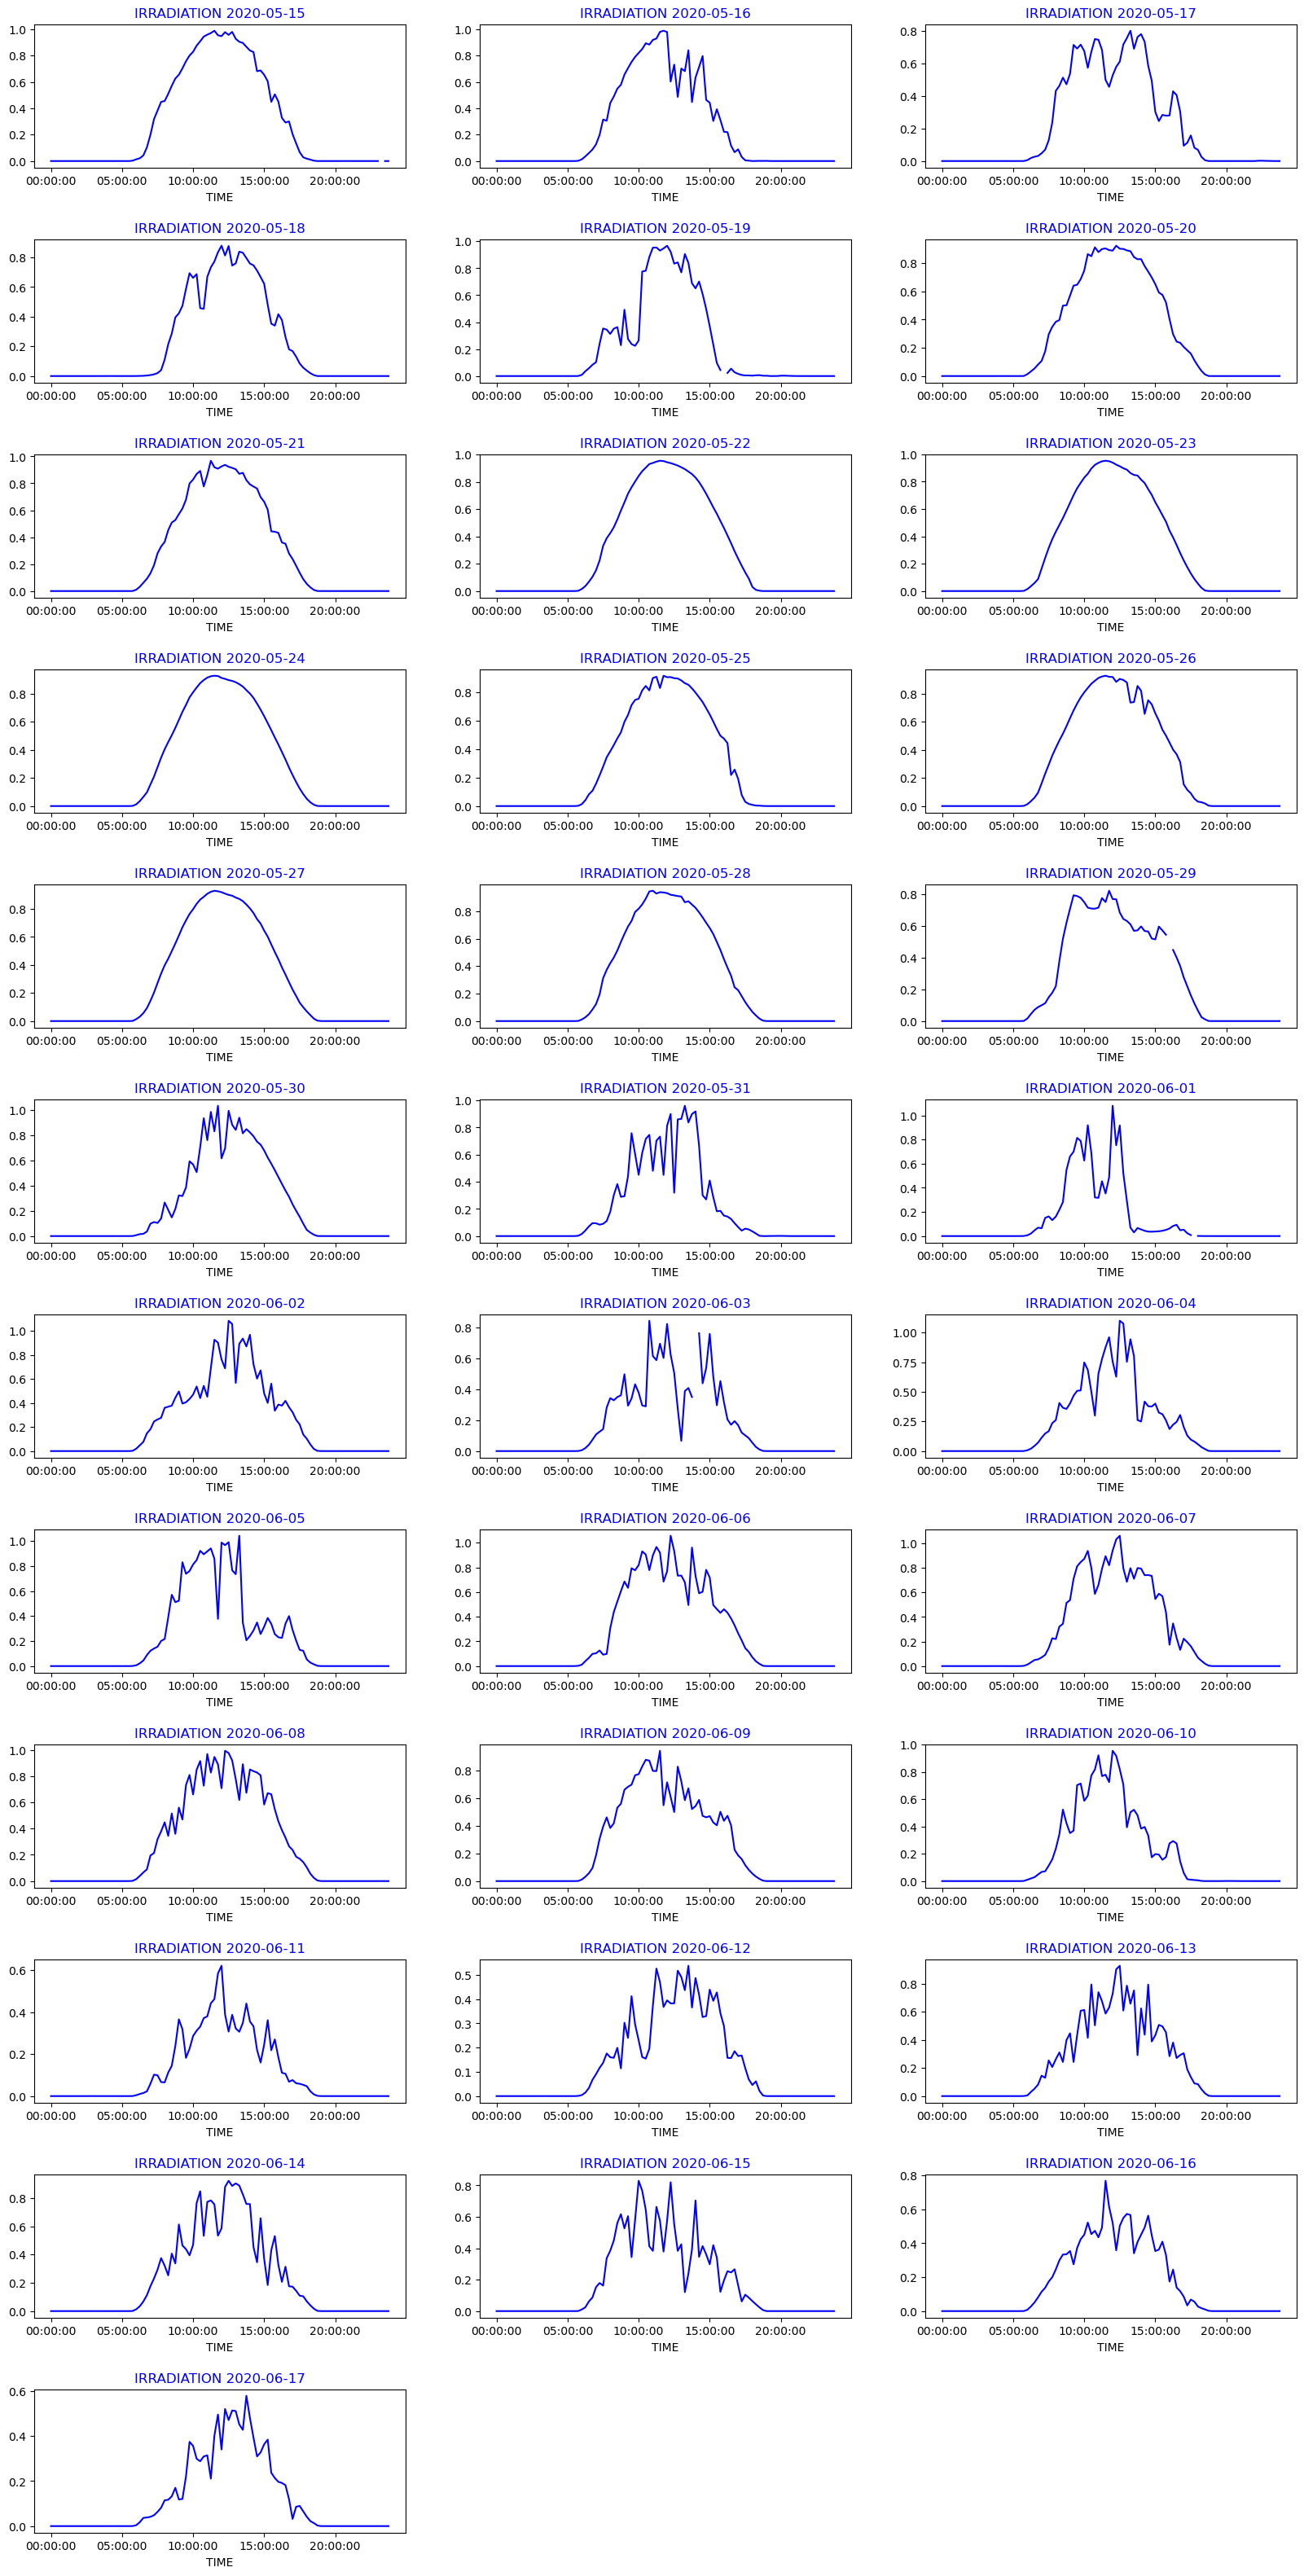

In [15]:
solar_irradiation = df_solar.pivot_table(values='IRRADIATION', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='blue')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_irradiation, row=12, col=3)

IRRADIATION graph pattern is looking very similar to the corresponding DC_POWER generation on per day basis.

In solar power plant DC_POWER or Output power is mostly depends on IRRADIATION.

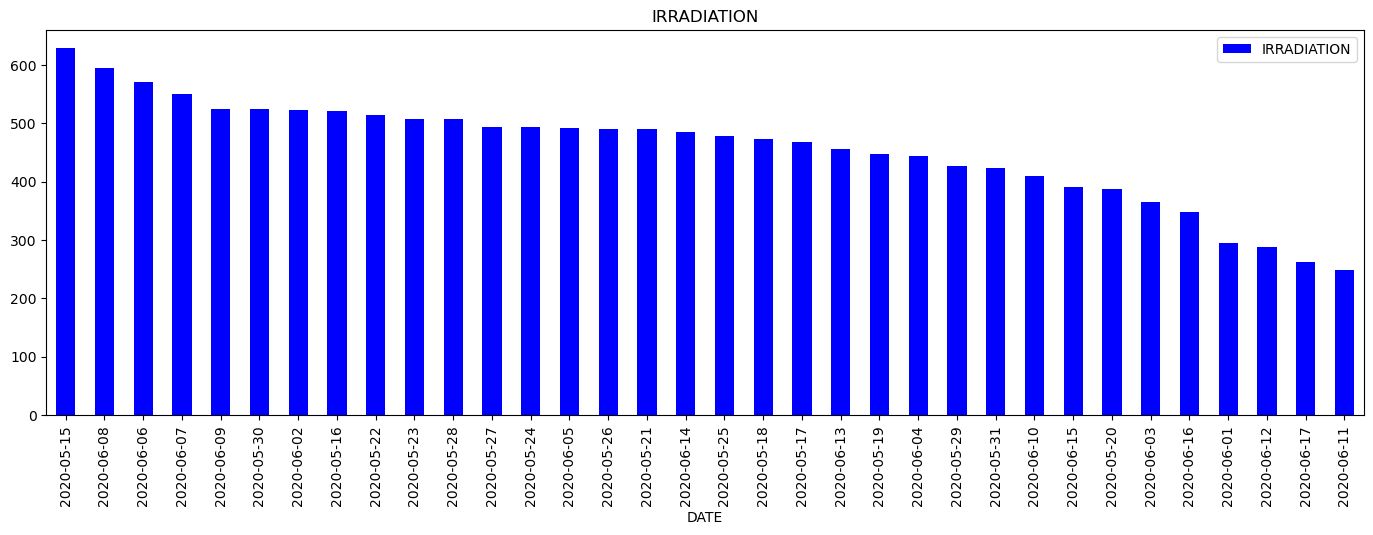

In [16]:
daily_irradiation = df_solar.groupby('DATE')['IRRADIATION'].agg('sum')

daily_irradiation.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='blue')
plt.title('IRRADIATION')
plt.show()

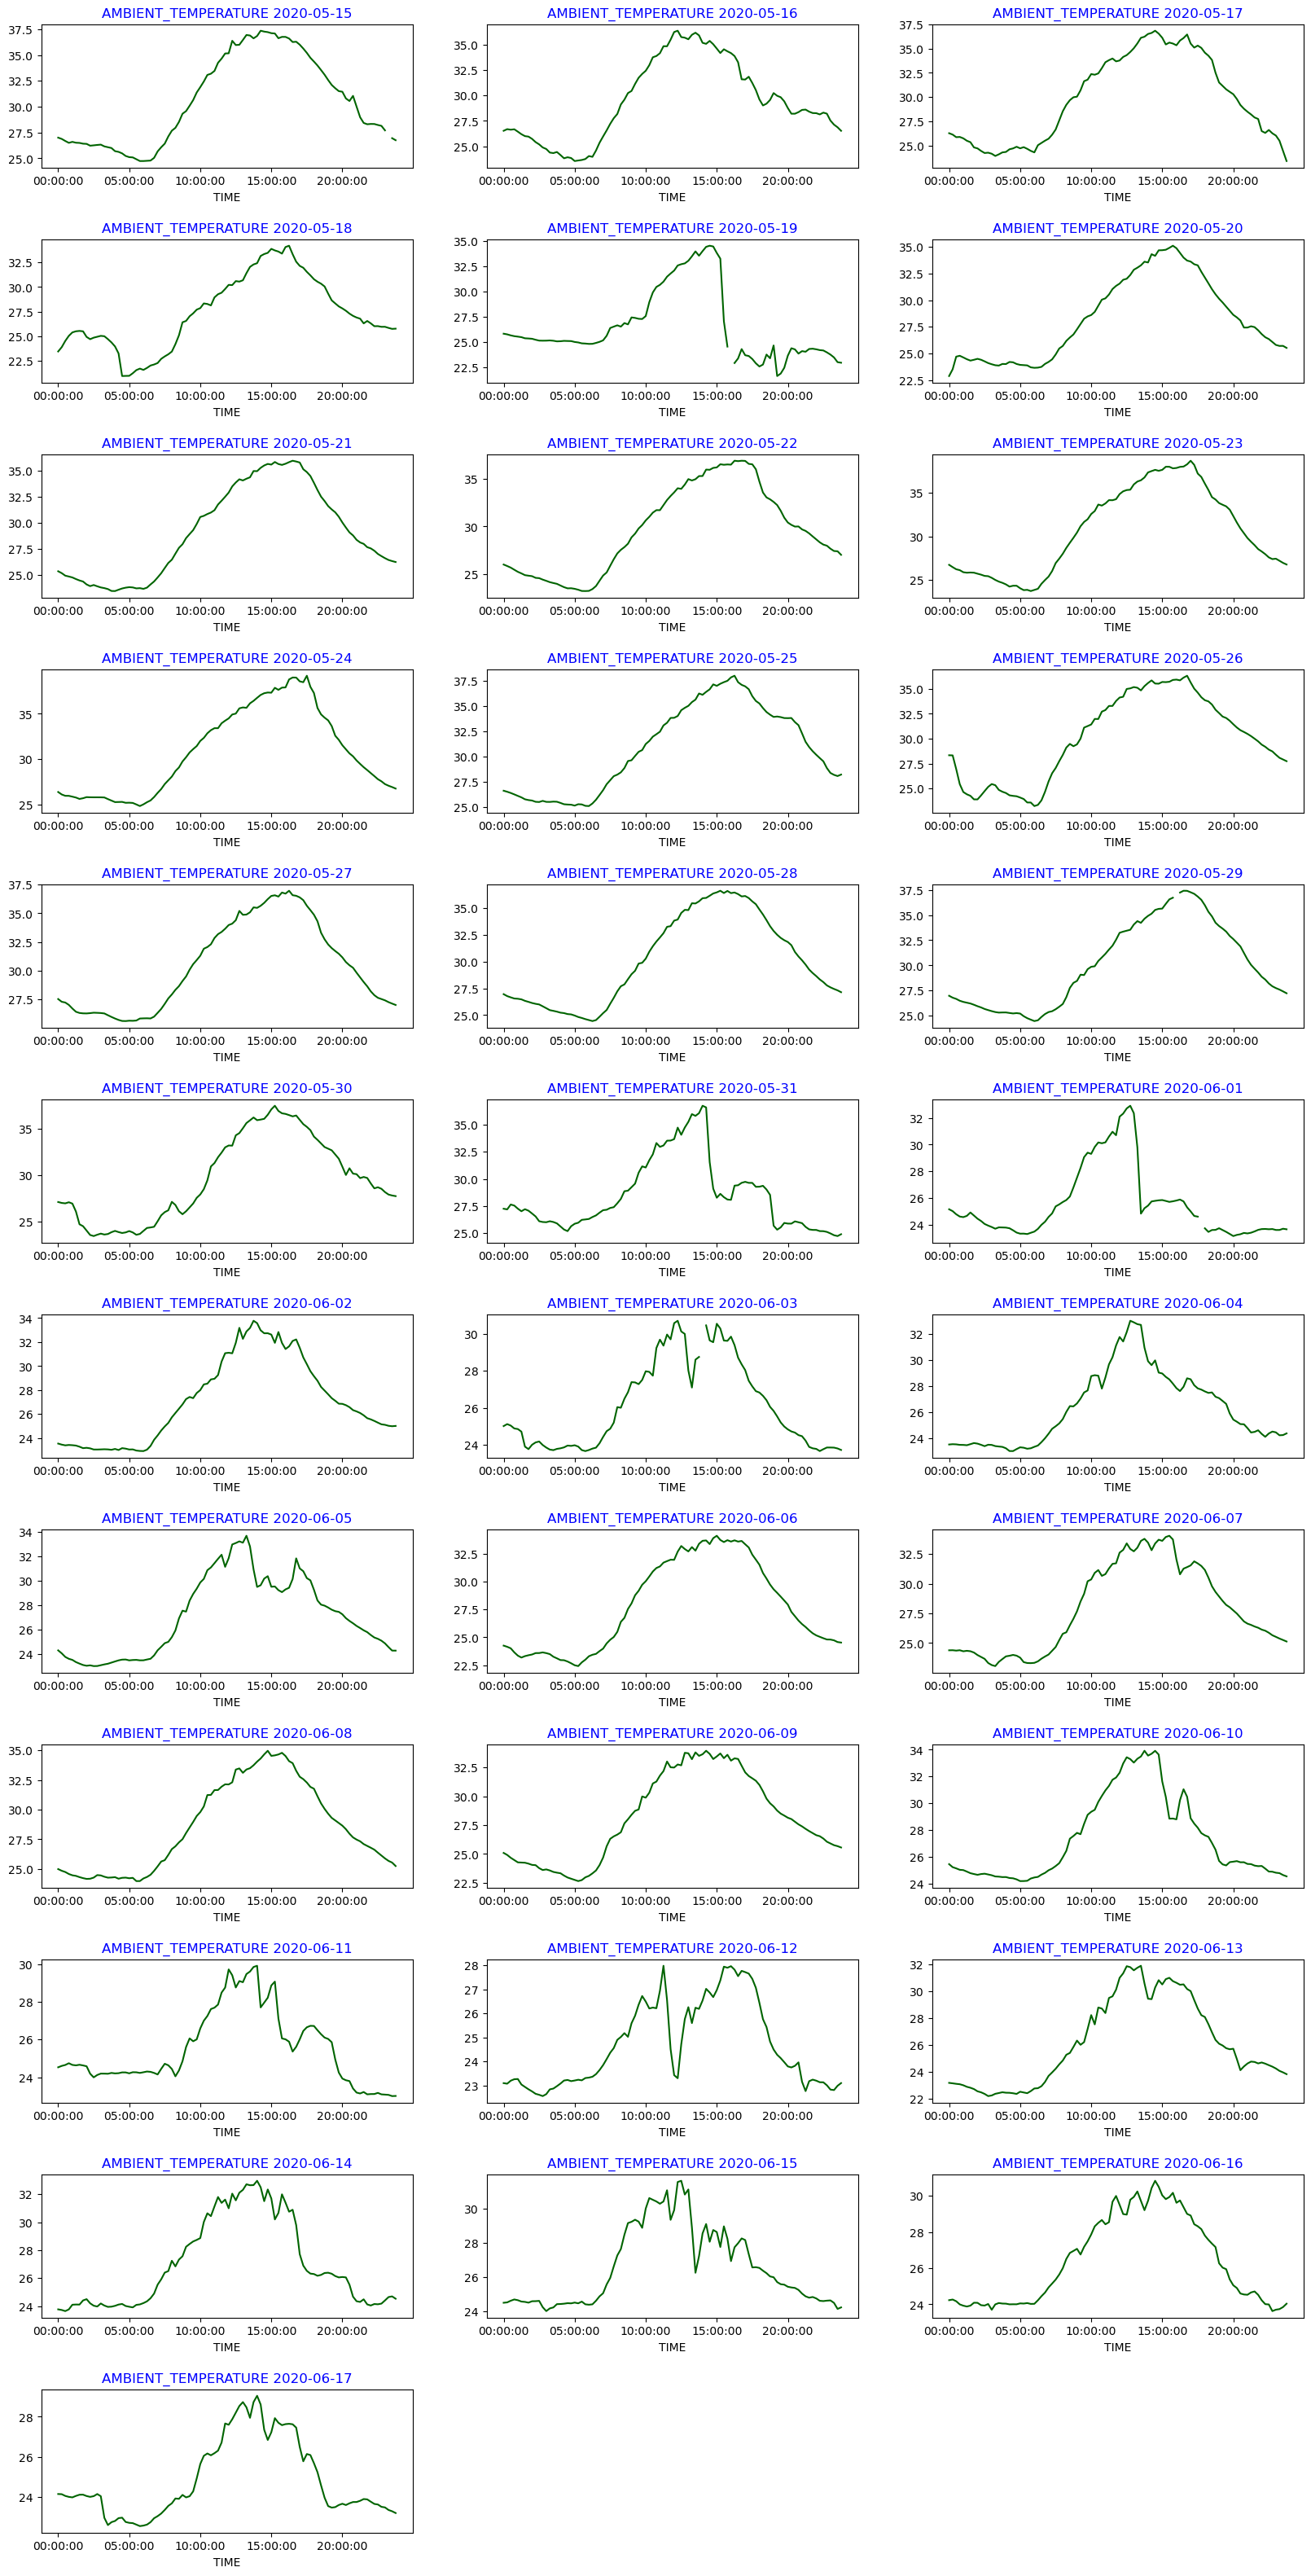

In [17]:
solar_ambiant_temp = df_solar.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='AMBIENT_TEMPERATURE'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='darkgreen')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_ambiant_temp, row=12, col=3)

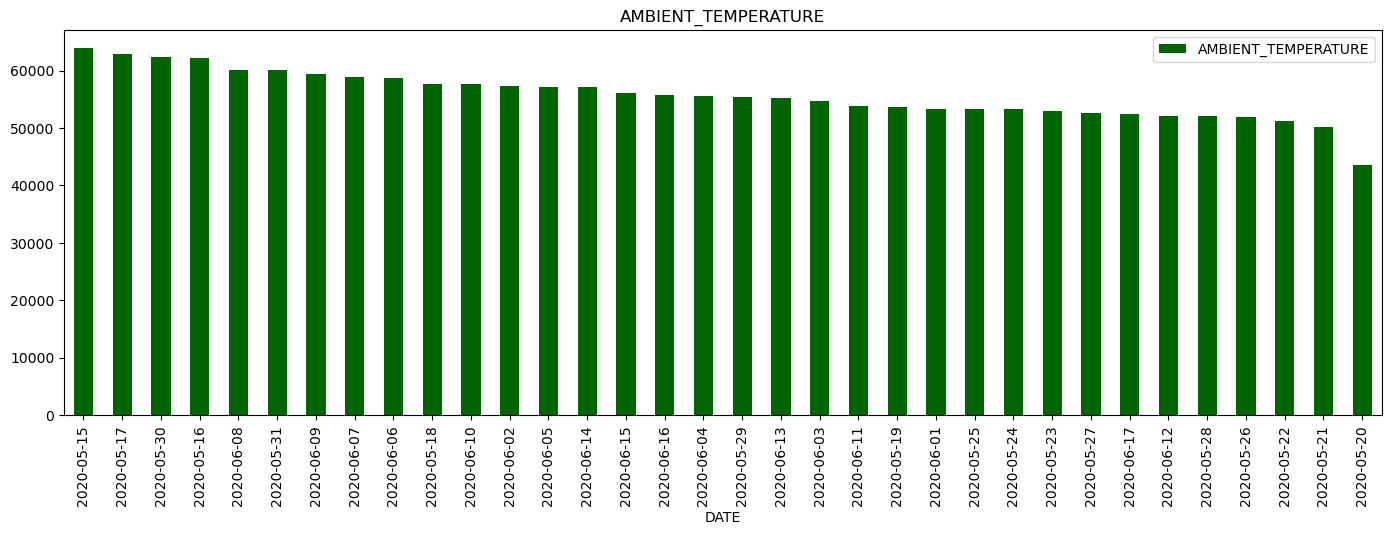

In [18]:
daily_ambient_temp = df_solar.groupby('DATE')['AMBIENT_TEMPERATURE'].agg('sum')

daily_ambient_temp.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkgreen')
plt.title('AMBIENT_TEMPERATURE')
plt.show()

## Highest and Lowest Power Generation Comparision

##### Highest average DC_POWER is generated on "2020-05-15"

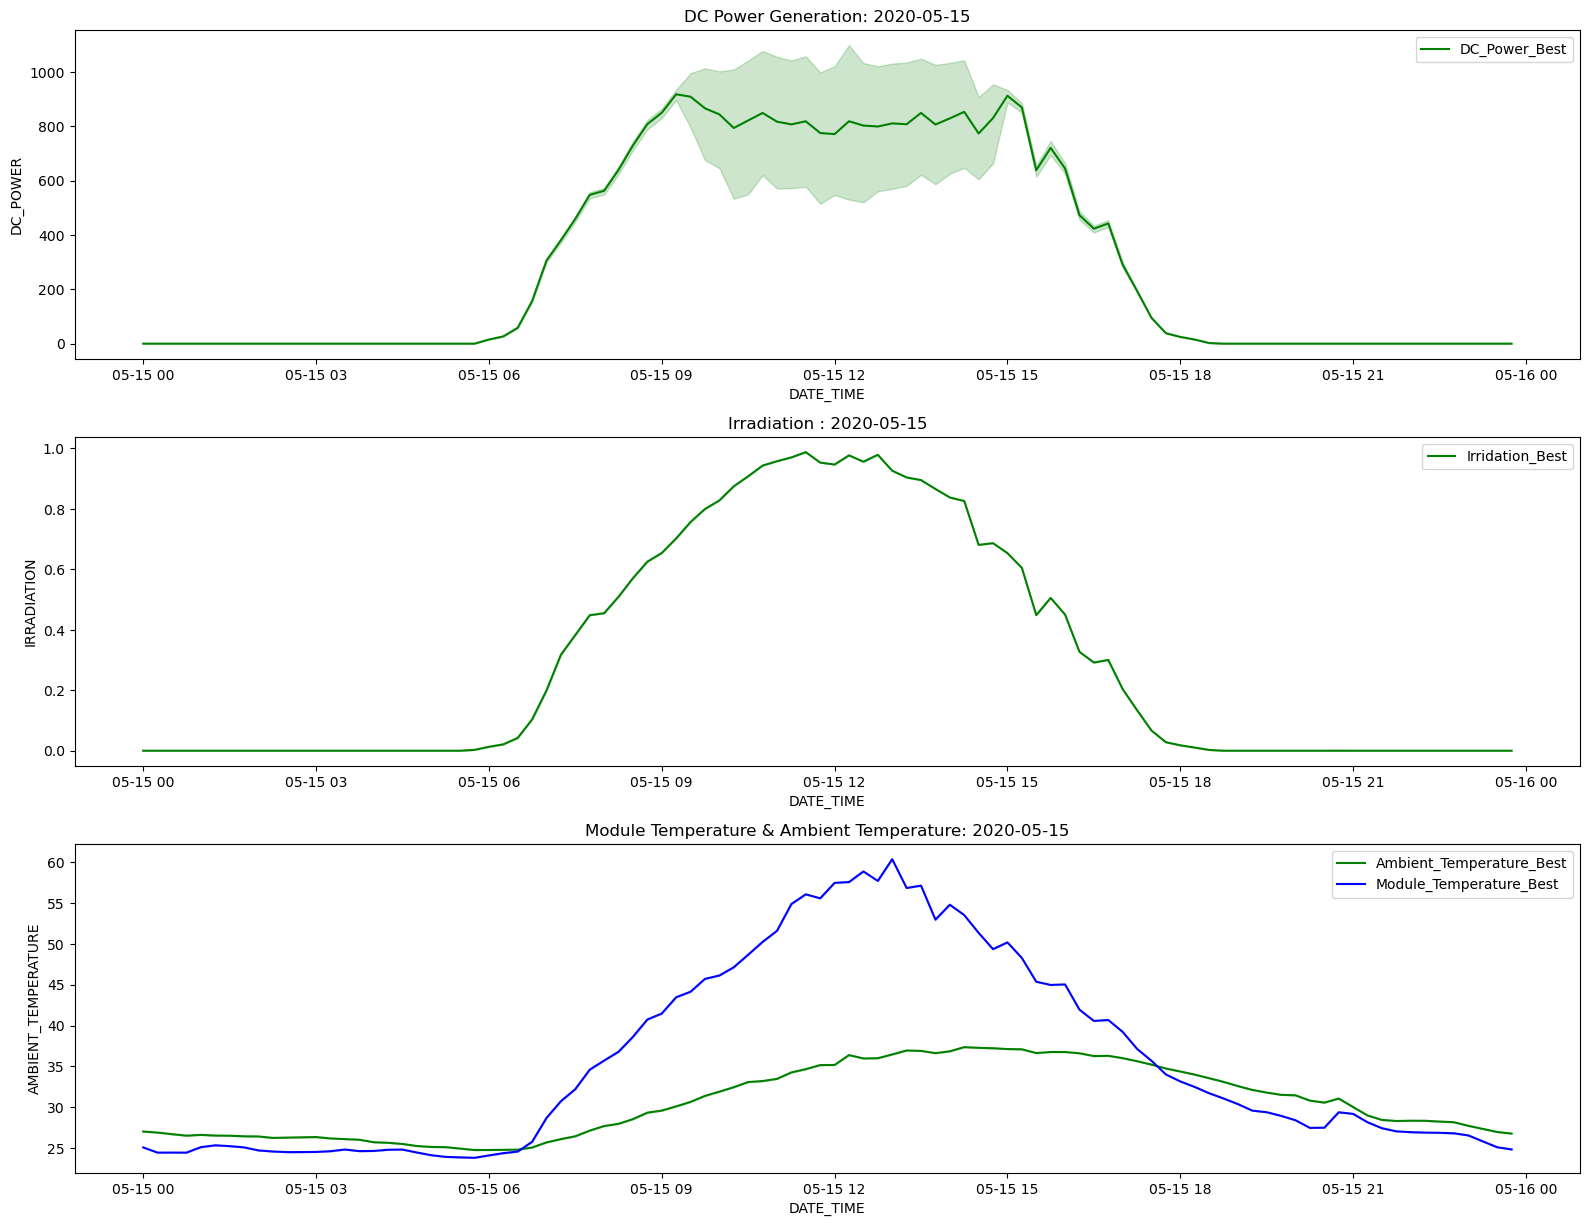

In [19]:
plt.figure(figsize=(16,16))

date=["2020-05-15"]

plt.subplot(411)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Best",color='green');
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Best",color='green');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(413)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Best",color='green');
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Best",color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

NOTE: Both DC_POWER graph and IRRADIATION graph is almost looking like an ideal graph. Weather is also looking good, and there is no cloud is in the sky because there is very less variation in IRRADIATION and temperature of the solar panel and ambient temperature.

#### Lowest average DC_POWER is generated on "2020-06-11"

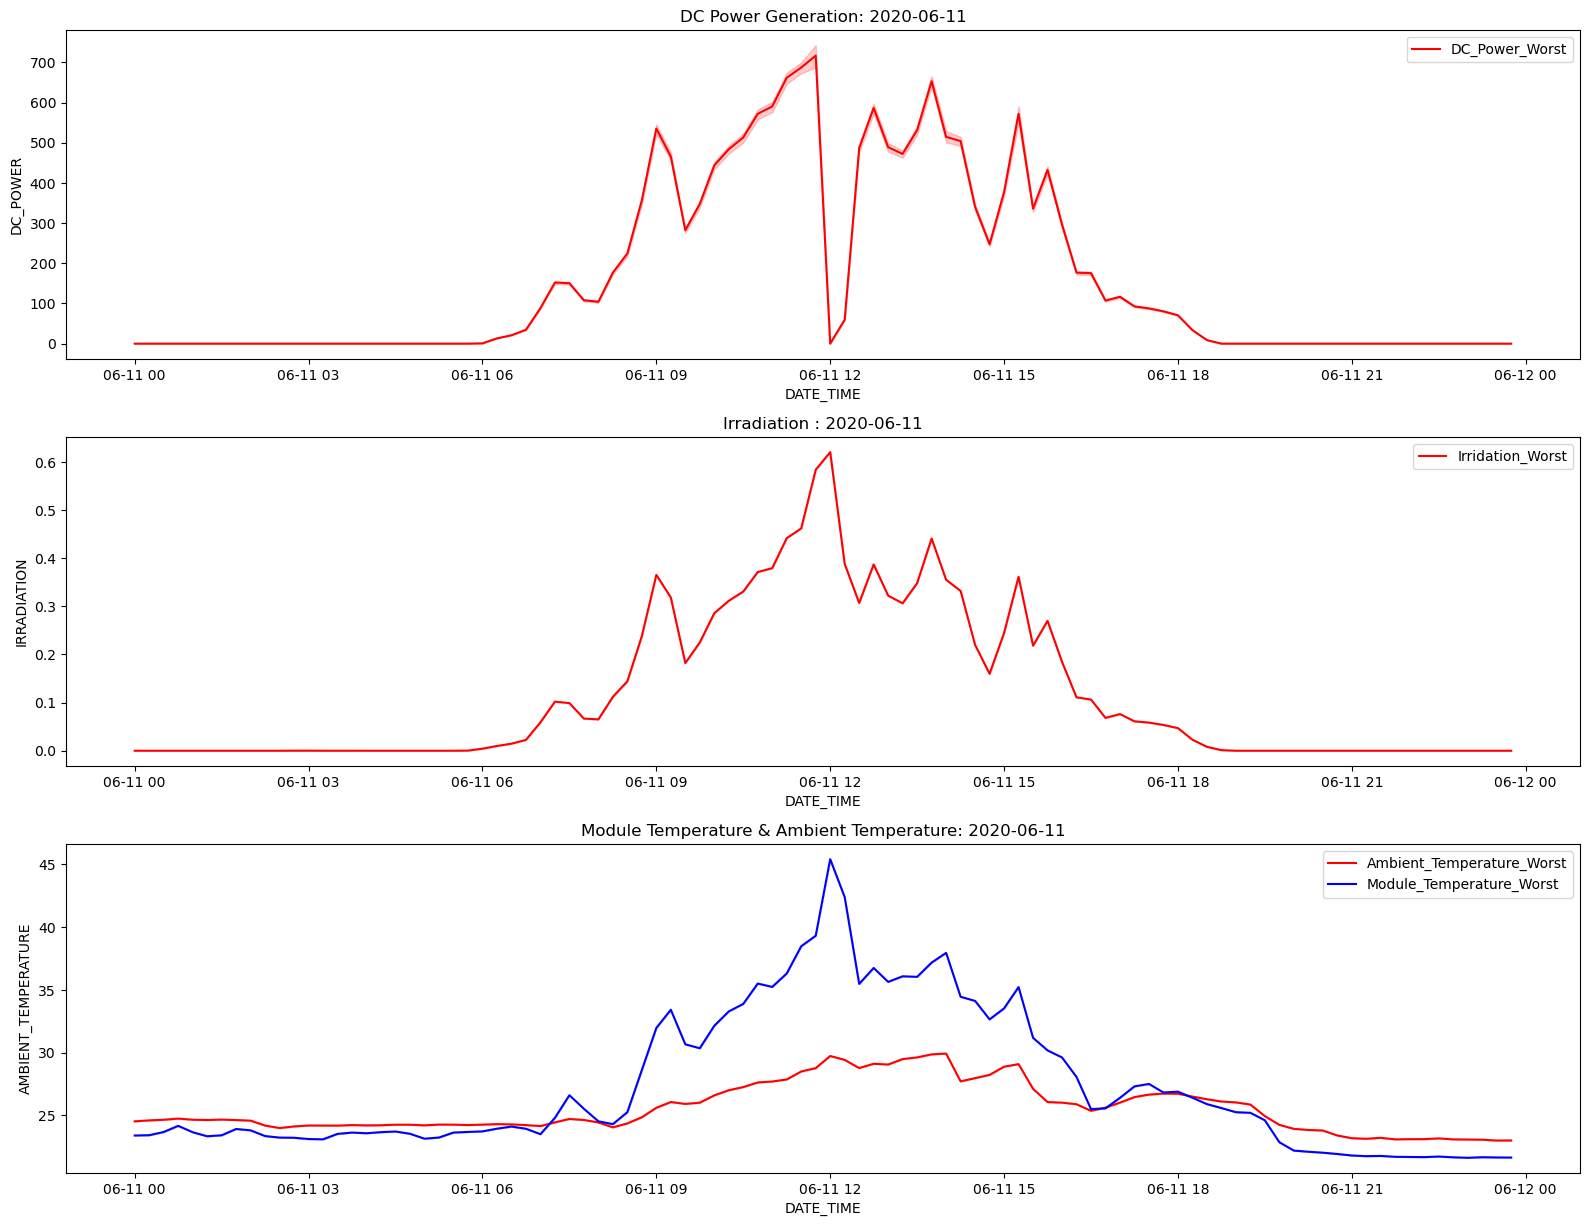

In [20]:
date=["2020-06-11"]
plt.figure(figsize=(16,16))

plt.subplot(411)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Worst",color='red');
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Worst",color='red');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(413)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Worst",color='red');
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Worst",color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

There are very large fluctuations in both DC_POWER graph and IRRADIATION graph

Possible Reasons for these large fluctuation in the DC_POWER, IRRADIATION, Ambient temperature, Module temperature:

- At about 12 O’clock there is a sharp decline in the DC_POWER generation from 700 to almost 20 KWatt. 

- And at the same time IRRADIATION fall from 0.6 to 0.3 almost half.

- Ambient temperature and Module temperature also fall drastically. Module temperature from 45 C to 35 C & Ambient temperature is also reduced. 

- The possible reason for this reduction is due to may be heavy rain and heavily clouded sky and bad weather. There is almost very less possibility of any fault in the system

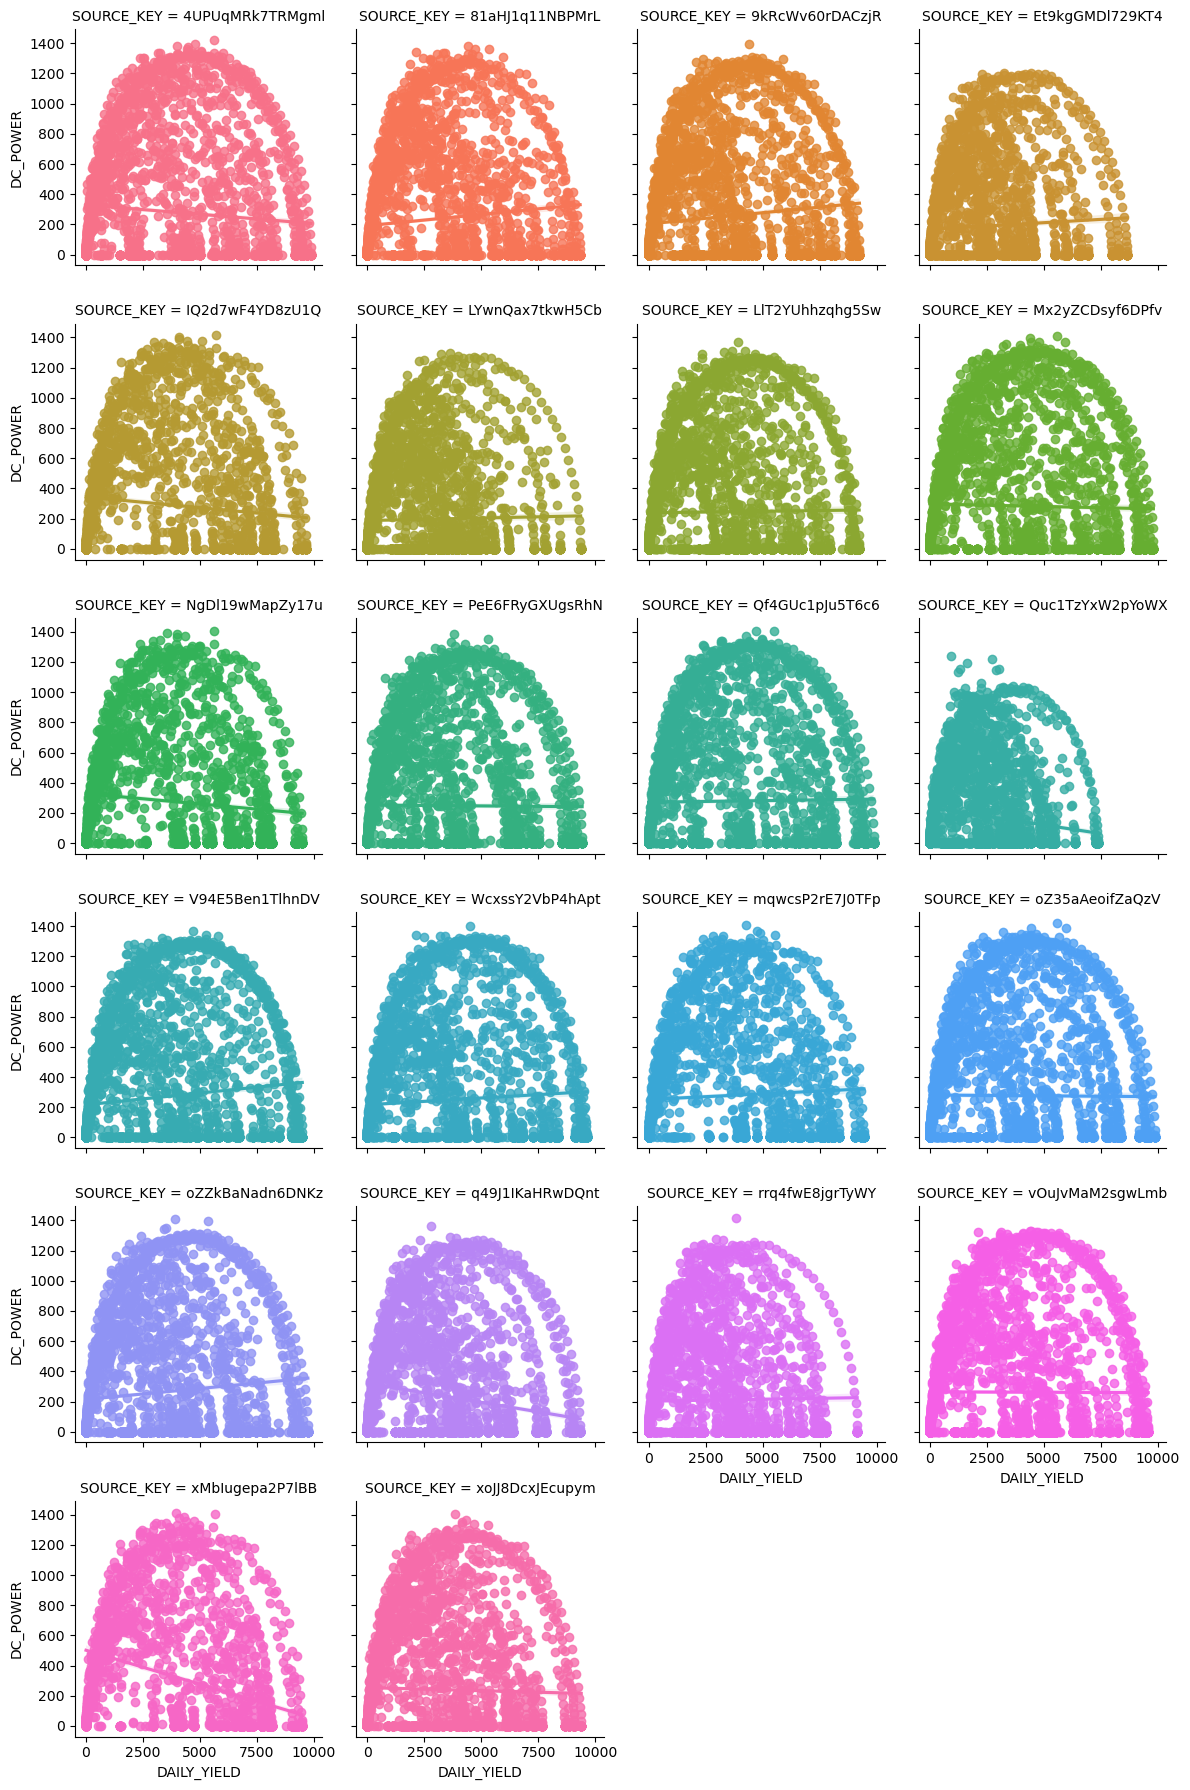

In [21]:
sns.lmplot(y="DC_POWER",x="DAILY_YIELD",hue="SOURCE_KEY",col="SOURCE_KEY",height=3,col_wrap=4,data=df_solar,fit_reg=True);

## Calculation Efficiency of Solar Power Plant Inverter  

In [22]:
solar_dc_power = df_solar[df_solar['DC_POWER'] > 0]['DC_POWER'].values
solar_ac_power = df_solar[df_solar['AC_POWER'] > 0]['AC_POWER'].values

In [23]:
solar_plant_eff = (np.max(solar_ac_power)/np.max(solar_dc_power ))*100
print("Inverter Efficiency of Solar Power Plant:  {solar_plant_eff:0.3f} %")

Inverter Efficiency of Solar Power Plant:  {solar_plant_eff:0.3f} %


In [24]:
AC_list=[]
for i in df_solar['AC_POWER']:
    if i>0:
        AC_list.append(i)
AC_list
len(AC_list)

32036

In [25]:
#Here we take all nonzero DC values and plot them on histogram
DC_list=[]
for i in df_solar['DC_POWER']:
    if i>0:
        DC_list.append(i)
DC_list
# DC_list.sort()
# DC_list.reverse()
len(DC_list)

32036

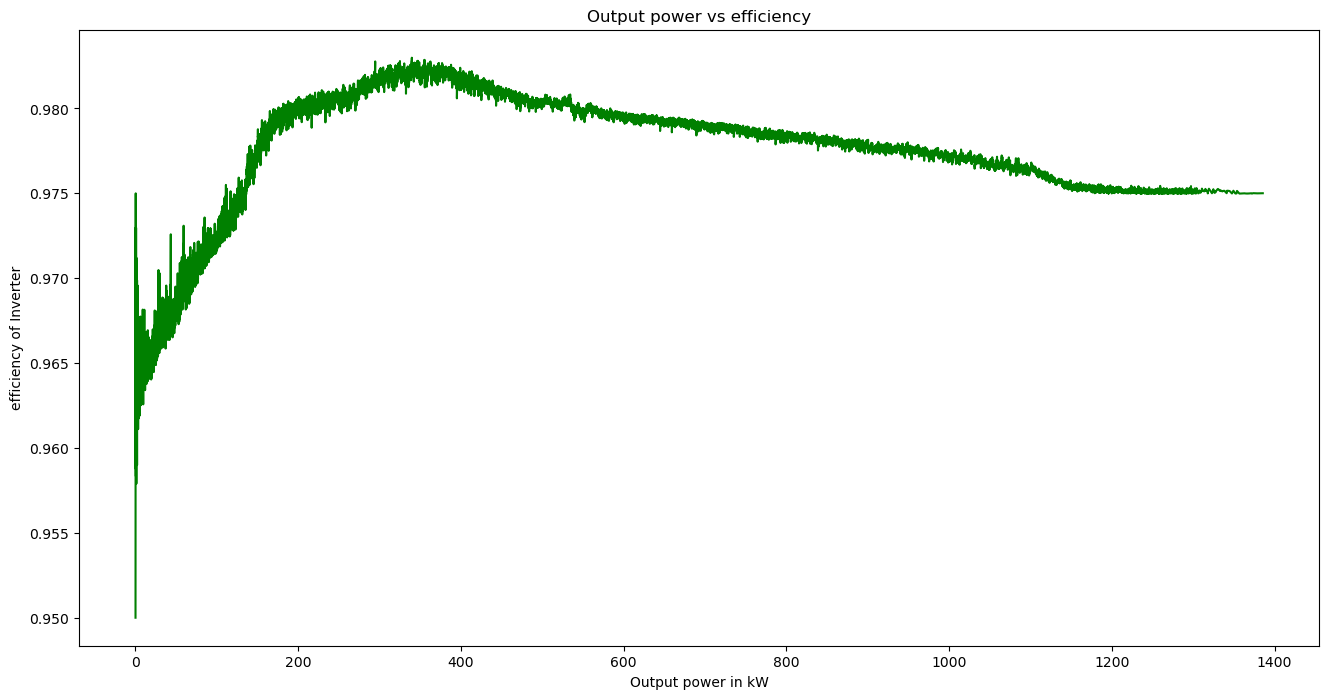

In [26]:
plt.figure(figsize=(16,8))
AC_list.sort()
DC_list.sort()

eff = [i/j for i,j in zip(AC_list,DC_list)]

plt.plot(AC_list,eff,color='green')
plt.xlabel('Output power in kW')
plt.ylabel('efficiency of Inverter')
plt.title('Output power vs efficiency');

## Prediction Solar Power Generation

In [27]:
df2 = df_solar.copy()
X = df2[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]
y = df2['AC_POWER']

In [28]:
X.head()

,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER
0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,0.0
1,0.000000,1.215279e+09,27.004764,25.060789,0.0,0.0
2,3075.333333,2.247720e+09,27.004764,25.060789,0.0,0.0
3,269.933333,1.704250e+06,27.004764,25.060789,0.0,0.0
4,3177.000000,1.994153e+07,27.004764,25.060789,0.0,0.0


In [29]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: AC_POWER, dtype: float64

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=21)

##### Linear Regression Model

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
score_lr = 100*lr_clf.score(X_test,y_test)
print(f'LR Model score = {score_lr:4.4f}%')

LR Model score = 99.9994%


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
R2_Score_lr = round(r2_score(y_pred_lr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_lr,"%")

R2 Score :  100.0 %


##### Random Forest Regressor Model

In [33]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)


RandomForestRegressor()

In [34]:
y_pred_rfr = lr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_rfr,"%")

R2 Score :  100.0 %


##### Decision Tree Regressor Model

In [35]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [36]:
y_pred_dtr = lr.predict(X_test)
R2_Score_dtr = round(r2_score(y_pred_dtr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_dtr,"%")

R2 Score :  100.0 %


In [37]:
prediction = rfr.predict(X_test)
print(prediction)

[   0.            0.          684.74934762 ...    0.         1007.16555714
    0.        ]


In [38]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction})
cross_checking.head()

,Actual,Predicted
40426,0.000000,0.000000
50974,0.000000,0.000000
53919,684.913333,684.749348
2384,0.000000,0.000000
22014,0.000000,0.000000


In [39]:
cross_checking['Error'] = cross_checking['Actual'] - cross_checking['Predicted']
cross_checking.head()

,Actual,Predicted,Error
40426,0.000000,0.000000,0.000000
50974,0.000000,0.000000,0.000000
53919,684.913333,684.749348,0.163986
2384,0.000000,0.000000,0.000000
22014,0.000000,0.000000,0.000000


In [40]:
cross_checking_final  = cross_checking[cross_checking['Error'] <= 20]
cross_checking_final.sample(25)

,Actual,Predicted,Error
59312,0.000000,0.000000,0.000000
46076,58.940000,58.995407,-0.055407
37650,12.364286,12.383895,-0.019610
52664,0.000000,0.000000,0.000000
15067,0.000000,0.000000,0.000000
35072,911.373333,910.811633,0.561700
11016,1244.960000,1244.976852,-0.016852
38964,672.926667,672.938671,-0.012005
3492,469.980000,469.745390,0.234610
60666,434.793333,434.912910,-0.119576


In this way we can predict and forecast the power generation of any solar power plant.